# DLVC WS 2017

Tutorial 8: Cost Functions and their Properties
==

Load Packages
==

In [1]:
%matplotlib inline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_ssim

Load Data:
===============

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 100

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

In [3]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

Define the Autoencoder:
===============

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 256),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(256, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net1 = autoencoder()
net2 = autoencoder()

if use_gpu:
    net1 = net1.double().cuda()
    net2 = net2.double().cuda()
else:
    net1 = net1.double()
    net2 = net2.double()
        

Train Autoencoder:
===========

In [5]:
def Train(model,optimizer,criterion,IP,LB):
    optimizer.zero_grad()
    OP = model(IP)
    loss = criterion(OP, LB)
    loss.backward()
    optimizer.step()

At Epoch 1 ; SSIM Index (MSE):  0.835683 ; SSIM Index (L1):  0.758024 
At Epoch 2 ; SSIM Index (MSE):  0.905303 ; SSIM Index (L1):  0.779852 
At Epoch 3 ; SSIM Index (MSE):  0.916792 ; SSIM Index (L1):  0.794212 
At Epoch 4 ; SSIM Index (MSE):  0.932649 ; SSIM Index (L1):  0.801741 
At Epoch 5 ; SSIM Index (MSE):  0.934476 ; SSIM Index (L1):  0.804218 
At Epoch 6 ; SSIM Index (MSE):  0.941023 ; SSIM Index (L1):  0.807517 
At Epoch 7 ; SSIM Index (MSE):  0.947833 ; SSIM Index (L1):  0.808846 
At Epoch 8 ; SSIM Index (MSE):  0.954612 ; SSIM Index (L1):  0.808986 
At Epoch 9 ; SSIM Index (MSE):  0.954529 ; SSIM Index (L1):  0.809353 
At Epoch 10 ; SSIM Index (MSE):  0.957783 ; SSIM Index (L1):  0.809328 
Finished Training


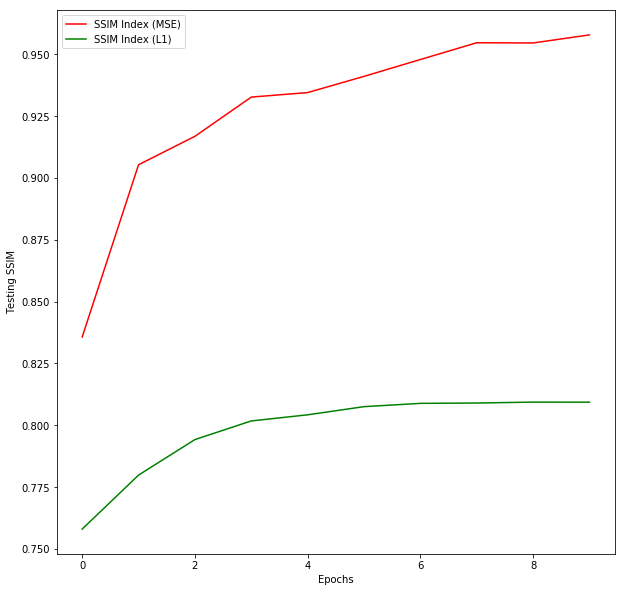

In [6]:
iterations = 10

optimizer1 = optim.Adam(net1.parameters(), lr=1e-4)
optimizer2 = optim.Adam(net2.parameters(), lr=1e-4)

criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()

Plotssim1 = []
Plotssim2 = []

dataiter = iter(testloader)
images, labels = dataiter.next()
if use_gpu:
    testinputs = Variable(images[0].view(-1, 28*28).double()).cuda()
else:
    testinputs = Variable(images[0].view(-1, 28*28).double()) 

for epoch in range(iterations):  # loop over the dataset multiple times
    ssim1 = 0.0
    ssim2 = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.view(-1, 28*28).double()).cuda()
        else:
            inputs = Variable(inputs.view(-1, 28*28).double())
        Train(net1,optimizer1,criterion1,inputs,inputs)
        Train(net2,optimizer2,criterion2,inputs,inputs)        
    outputs = net1(testinputs)
    ssim1 = pytorch_ssim.ssim(Variable(testinputs.data.view(1,1,28,28).double()), Variable(outputs.data.view(1,1,28,28).double()))
    outputs = net2(testinputs)
    ssim2 = pytorch_ssim.ssim(Variable(testinputs.data.view(1,1,28,28).double()), Variable(outputs.data.view(1,1,28,28).double()))
    Plotssim1.append(float(ssim1))
    Plotssim2.append(float(ssim2))
    print('At Epoch %d ; SSIM Index (MSE):  %f ; SSIM Index (L1):  %f '%((epoch+1),ssim1,ssim2))
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
fig = plt.figure()         
plt.plot(range(epoch+1),Plotssim1,'r-',label='SSIM Index (MSE)')
plt.plot(range(epoch+1),Plotssim2,'g-',label='SSIM Index (L1)')      
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Testing SSIM')  
print('Finished Training')

Neural Network: 
================================

In [7]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.Layer1 = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 256),
            nn.ReLU())
        self.Layer2 = nn.Sequential(
            nn.Linear(256, 10),
            nn.LogSoftmax())

    def forward(self, x):
        x = self.Layer1(x)
        x = self.Layer2(x)
        return x


net1 = NeuralNet()
net2 = NeuralNet()

if use_gpu:
    net1 = net1.double().cuda()
    net2 = net2.double().cuda()
else:
    net1 = net1.double()
    net2 = net2.double()

Train Classifier:
===========

/home/iteradmin/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Epoch 1 ; Acc (Cross Entropy):  0.166500 ; Acc (Negative Log Likelihood):  0.166500 
At Epoch 2 ; Acc (Cross Entropy):  0.419600 ; Acc (Negative Log Likelihood):  0.419600 
At Epoch 3 ; Acc (Cross Entropy):  0.568600 ; Acc (Negative Log Likelihood):  0.568600 
At Epoch 4 ; Acc (Cross Entropy):  0.633000 ; Acc (Negative Log Likelihood):  0.633000 
At Epoch 5 ; Acc (Cross Entropy):  0.662200 ; Acc (Negative Log Likelihood):  0.662200 
At Epoch 6 ; Acc (Cross Entropy):  0.679500 ; Acc (Negative Log Likelihood):  0.679500 
At Epoch 7 ; Acc (Cross Entropy):  0.691900 ; Acc (Negative Log Likelihood):  0.691900 
At Epoch 8 ; Acc (Cross Entropy):  0.709400 ; Acc (Negative Log Likelihood):  0.709400 
At Epoch 9 ; Acc (Cross Entropy):  0.727800 ; Acc (Negative Log Likelihood):  0.727800 
At Epoch 10 ; Acc (Cross Entropy):  0.755600 ; Acc (Negative Log Likelihood):  0.755600 
Finished Training


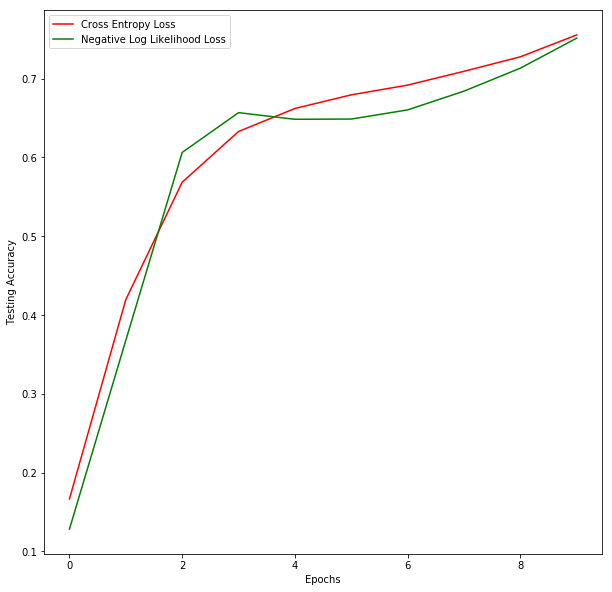

In [8]:
iterations = 10
learning_rate = 0.9
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.NLLLoss()

optimizer1 = optim.SGD(net1.parameters(), lr=1e-3)
optimizer2 = optim.SGD(net2.parameters(), lr=1e-3)

Plotacc1 = []
Plotacc2 = []

for epoch in range(iterations):  # loop over the dataset multiple times

    correct1 = 0
    correct2 = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), Variable(labels).cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), Variable(labels)
            
        Train(net1,optimizer1,criterion1,inputs,labels)
        Train(net2,optimizer2,criterion2,inputs,labels)
        
    for data in testloader:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()).cuda(), labels.cuda()
        else:
            inputs, labels = Variable(inputs.view(-1, 28*28).double()), labels
        total += labels.size(0)
        
        outputs = net1(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct1 += (predicted == labels).sum()
        
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct2 += (predicted == labels).sum()

    Plotacc1.append(correct1/float(total))
    Plotacc2.append(correct2/float(total))
    print('At Epoch %d ; Acc (Cross Entropy):  %f ; Acc (Negative Log Likelihood):  %f '%((epoch+1),correct1/float(total),correct1/float(total)))
fig = plt.figure()        
plt.plot(range(epoch+1),Plotacc1,'r-',label='Cross Entropy Loss')
plt.plot(range(epoch+1),Plotacc2,'g-',label='Negative Log Likelihood Loss')     
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')  
print('Finished Training')